In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score

import warnings
warnings.filterwarnings("ignore")

try:
    df_spot_led = pd.read_csv("outputs/model1_spot_led_microstructure.csv")
    df_fut_led = pd.read_csv("outputs/model2_fut_led_microstructure.csv")

    full_spot_ticks = pd.read_csv("TRB_USDT/Archive/trb_usdt_spot_export.csv")
    full_spot_ticks["time"] = pd.to_datetime(full_spot_ticks["time"])
    full_spot_ticks["mid_price"] = (
        full_spot_ticks["bid_price"] + full_spot_ticks["ask_price"]
    ) / 2
    full_spot_ticks.sort_values("time", inplace=True)

    full_futures_ticks = pd.read_csv("TRB_USDT/Archive/trb_usdt_futures_export.csv")
    full_futures_ticks["time"] = pd.to_datetime(full_futures_ticks["time"])
    full_futures_ticks["mid_price"] = (
        full_futures_ticks["bid_price"] + full_futures_ticks["ask_price"]
    ) / 2
    full_futures_ticks.sort_values("time", inplace=True)
    
    print(f"Spot-Led Events: {len(df_spot_led)}")
    print(f"Futures-Led Events: {len(df_fut_led)}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    exit()

Spot-Led Events: 15006
Futures-Led Events: 21457


### 2. ANALYSIS FOR SPOT-LED MODEL (Spot -> Futures) 

In [3]:
features = [
    "time_since_prev_shock",
    "abs_shock_size",
    "past_trade_vol_10ms",
    "spread",
]
X_spot = df_spot_led[features]
y_spot = df_spot_led["target_fut_followed"] 

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_spot, y_spot, test_size=0.2, random_state=42,shuffle=False
)

xgb_spot = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42
)
xgb_spot.fit(X_train_s, y_train_s)
preds_spot = xgb_spot.predict(X_test_s)

print("\n--- XGBoost Results for SPOT-LED Model ---")
print(classification_report(y_test_s, preds_spot))



--- XGBoost Results for SPOT-LED Model ---
              precision    recall  f1-score   support

           0       0.37      0.18      0.24      1018
           1       0.67      0.84      0.74      1984

    accuracy                           0.62      3002
   macro avg       0.52      0.51      0.49      3002
weighted avg       0.57      0.62      0.58      3002



### Feature Importance for Spot-Led Model


Feature Importance Scores:
past_trade_vol_10ms      0.256451
abs_shock_size           0.252911
time_since_prev_shock    0.251167
spread                   0.239471
dtype: float32


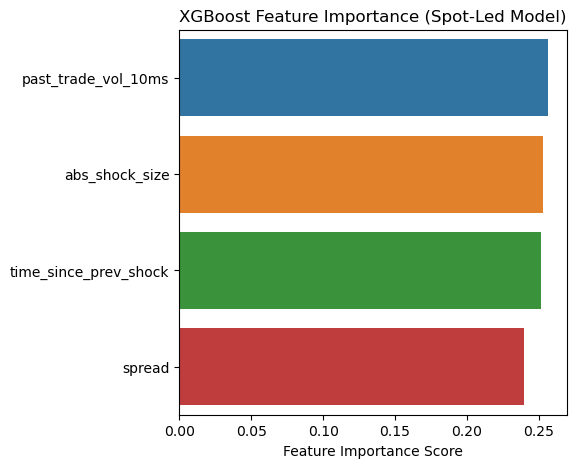

In [4]:
feature_importances_spot = pd.Series(
    xgb_spot.feature_importances_, index=X_train_s.columns
).sort_values(ascending=False)
print("\nFeature Importance Scores:")
print(feature_importances_spot)

plt.figure(figsize=(5, 5))
sns.barplot(x=feature_importances_spot, y=feature_importances_spot.index)
plt.title("XGBoost Feature Importance (Spot-Led Model)")
plt.xlabel("Feature Importance Score")
plt.show()


### 3. ANALYSIS FOR FUTURES-LED MODEL (Futures -> Spot) ###

In [6]:
X_fut = df_fut_led[features]
y_fut = df_fut_led["target_spot_followed"] 
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fut, y_fut, test_size=0.2, random_state=42, shuffle=False
)

xgb_fut = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_fut.fit(X_train_f, y_train_f)
preds_fut = xgb_fut.predict(X_test_f)

print("\n--- XGBoost Results for FUTURES-LED Model ---")
print(classification_report(y_test_f, preds_fut))


# This means: "Of all the times the model predicted a 'follow', how often was it right?"
model_hit_rate = precision_score(y_test_f, preds_fut, pos_label=1)

print(f"Model Hit Rate (Precision for 'Follow' class): {model_hit_rate:.2%}")
print(
    "This means when the model generates a signal, it is correct this percentage of the time."
)




--- XGBoost Results for FUTURES-LED Model ---
              precision    recall  f1-score   support

           0       0.32      0.11      0.17      1026
           1       0.77      0.92      0.84      3266

    accuracy                           0.73      4292
   macro avg       0.54      0.52      0.50      4292
weighted avg       0.66      0.73      0.68      4292

Model Hit Rate (Precision for 'Follow' class): 76.82%
This means when the model generates a signal, it is correct this percentage of the time.


### Feature Importance for Futures-Led Model 


Feature Importance Scores:
time_since_prev_shock    0.293897
spread                   0.257304
past_trade_vol_10ms      0.225838
abs_shock_size           0.222961
dtype: float32


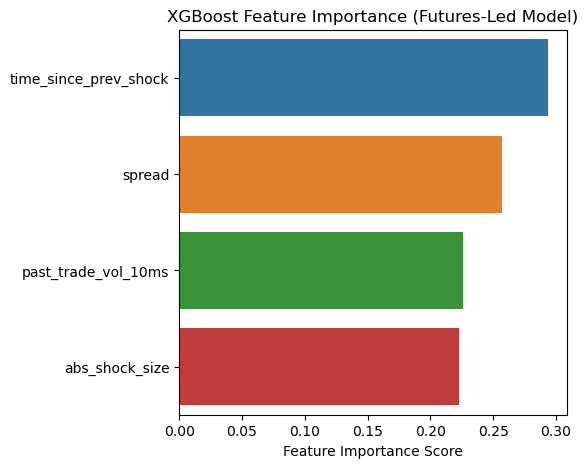

In [7]:

feature_importances_fut = pd.Series(
    xgb_fut.feature_importances_, index=X_train_f.columns
).sort_values(ascending=False)
print("\nFeature Importance Scores:")
print(feature_importances_fut)

plt.figure(figsize=(5, 5))
sns.barplot(x=feature_importances_fut, y=feature_importances_fut.index)
plt.title("XGBoost Feature Importance (Futures-Led Model)")
plt.xlabel("Feature Importance Score")
plt.show()

In [ ]:
### Simple HIGH-VOLUME Threshold Model (Spot-Led)
train_df_s = pd.concat([X_train_s, y_train_s], axis=1)
best_hit_rate_s = 0
best_threshold_s = 0

# For spot-led, I hypothesize HIGH volume is predictive
for p in np.linspace(0.5, 0.99, 50):
    threshold = train_df_s["past_trade_vol_10ms"].quantile(p)
    high_vol_subset = train_df_s[train_df_s["past_trade_vol_10ms"] >= threshold]
    if len(high_vol_subset) > 0:
        hit_rate = high_vol_subset["target_fut_followed"].mean()
        if hit_rate > best_hit_rate_s:
            best_hit_rate_s = hit_rate
            best_threshold_s = threshold

print(f"Optimal HIGH Volume Threshold found: {best_threshold_s:.2f}")
print(f"Hit Rate on Best Training Subset: {best_hit_rate_s:.2%}")

threshold_preds_s = (X_test_s["past_trade_vol_10ms"] >= best_threshold_s).astype(int)
print("\nResults on UNSEEN Test Data:")
print(classification_report(y_test_s, threshold_preds_s))